# Plasma density initialization

This notebook illustrates the use of the multiple density profiles available in ZPIC. Please note that ZPIC will use a fixed charge per simulation particle in a species, so different densities are obtained by changing the number of particles placed in a cell.

The particles per cell parameter of the species object specifies the number of particles per cell that correspond to the reference density (1.0). If you require a large range of density values, this parameter should be set to a reasonably high value, otherwise you may have cells with zero particles in the low density regions.

## 1D Density profiles

ZPIC defaults to using a uniform density profile for particle species. To use a different density profile the user must create a `zpic.Density` object and set it as the `density` keyword when creating the particle species, e.g.

```python
density = zpic.Density( type = "step", start = 17.5 )
electrons = zpic.Species( "electrons", -1.0, 128, density = density )
```

The specific type of density profile is set through the `type` keyword when creating the `zpic.Density` object. Available options are:
* __"uniform"__ - (default) Uniform density
* __"step"__ - Step like density profile (0 before the step, 1 afterwards), the keyword `start` specifies the position of the step
* __"slab"__ - Slab like density profile (1 inside the slab, 0 outside), the keywords `start`/`end` specify the beginning/end of the slab
* __"ramp"__ - Linear density ramp, with 0 density outside the ramp region. The keywords `start`/`end` specify the beginning/end of the ramp, and the keyword `ramp` specifies the required density at these two points.
* __"custom"__ - Custom density profile. Density is specified through a custom function specified through the `custom` keyword. This function takes a single parameter specifying the position and returns the required density at that point.

The following cell illustrates the use of the multiple density profiles available in 1D ZPIC. Just uncomment the required line below the `# Density profile` line in the next cell to choose the density type to test.


Running simulation up to t = 10 ...
n = 527, t = 10.013
Done.


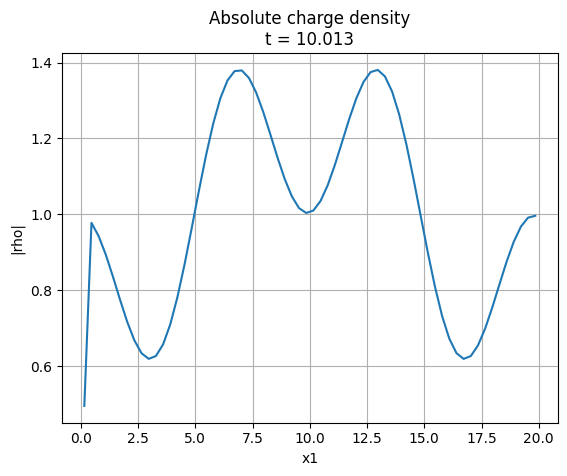

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d
import numpy as np

# Custom density profile
def custom_n0(x):
    return 1.0 + 0.5*np.sin(2*x/np.pi)*np.sin(x/np.pi) 

# Time step
dt = 0.019
tmax = 10.0

# Simulation box
nx  = 64
box = 20.0

# Diagnostic frequency
ndump = 100

# Density Profile
#density = em1d.Density( type = "uniform" )
#density = em1d.Density( type = "step", start = 17.5 )
#density = em1d.Density( type = "slab", start = 17.5, end = 22.5 )
#density = em1d.Density( type = "ramp", start = 17.5, end = 22.5, ramp = [1.0,2.0] )
density = em1d.Density( type = "custom", custom = custom_n0 )

# Background plasma
electrons = em1d.Species( "electrons", -1.0, 128, density = density )

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species = electrons )

# Set moving window
sim.set_moving_window()

# Run the simulation
sim.run( tmax )

# Plot the charge density at the end of the simulation
import matplotlib.pyplot as plt

charge = np.abs(electrons.charge())

xmin = sim.dx/2
xmax = sim.box - sim.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), charge ) 
plt.xlabel("x1")
plt.ylabel("|rho|")
plt.title("Absolute charge density\nt = {:g}".format(sim.t))

plt.grid(True)
plt.show()

## 2D Density profiles

Setting the density profile in 2D works the same way as in 1D. Available `zpic.Density` options are:

* __"uniform"__ - (default) Uniform density
* __"step"__ - Step like density profile along $x$ (0 before the step, 1 afterwards), the keyword `start` specifies the $x$ position of the step
* __"slab"__ - Slab like density profile along $x$ (1 inside the slab, 0 outside), the keywords `start`/`end` specify the $x$ poitison of the beginning/end of the slab
* __"custom"__ - Custom density profile. Density is specified using 2 custom functions specified through the `custom_x` and `custom_y` keywords. The density at each point will be `custom_x(x) * custom_y(y)`.

This following cell illustrates the use of the multiple density profiles available in 2D ZPIC. Just uncomment the required line below the `# Density profile` line in the next cell to choose the density type to test.


Running simulation up to t = 0.07 ...
n = 2, t = 0.14
Done.


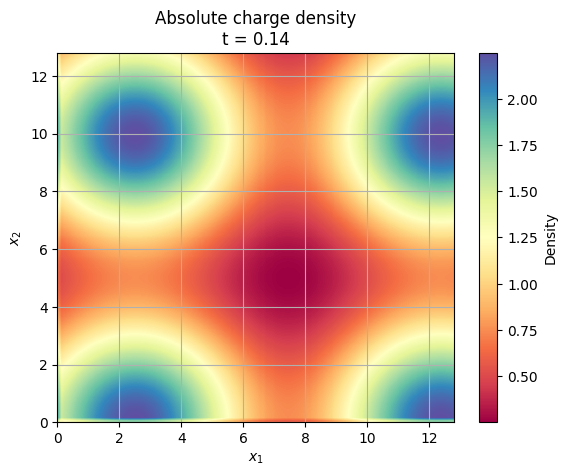

In [2]:
import em2d as zpic
import numpy as np

# Custom density profiles along x and y
def nx(x):
    return 1.0 + 0.5*np.sin(2*x/np.pi) 

def ny(y):
    return 1.0 + 0.5*np.cos(2*y/np.pi) 

# Time step
dt = 0.07
tmax = 0.07

# Density Profile
#density = zpic.Density( type = "uniform" )
#density = zpic.Density( type = "step", start = 6.4 )
#density = zpic.Density( type = "slab", start = 3.2, end = 9.6 )
density = zpic.Density( type = "custom", custom_x = nx, custom_y = ny )


# Background plasma
electrons = zpic.Species( "electrons", -1.0, ppc = [8,8], density = density )

# Initialize simulation data
sim = zpic.Simulation( nx = [128,128], box = [12.8,12.8], dt = 0.07, 
                       species = electrons )

# Run the simulation
sim.run( tmax )

import matplotlib.pyplot as plt

charge = np.abs(electrons.charge())
range = [[0,sim.box[0]],[0,sim.box[1]]]

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.imshow( charge, interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'Spectral' )
plt.colorbar().set_label('Density')

plt.title("Absolute charge density\nt = {:g}".format(sim.t))

plt.grid(True)
plt.show()

#### Extra: Dirac Delta Profiles

For the 2D spectral version of the code (em2ds) an extra density profile type is also defined:
* __"dirac"__ - Defines a profile which is a sum of Dirac deltas functions placed randomly inside the simulation box or at equally spaced positions. A single particle is initiallized for each of the chosen grid points.

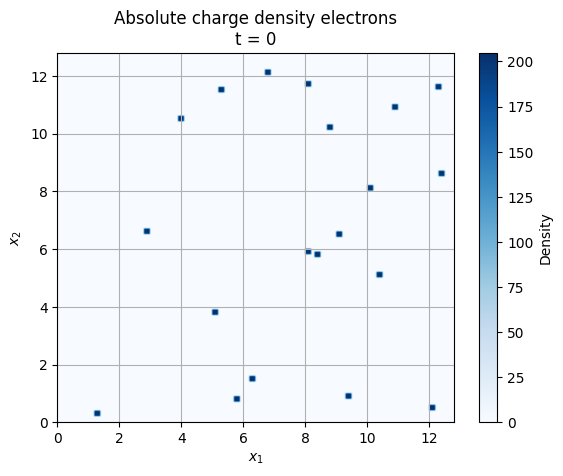

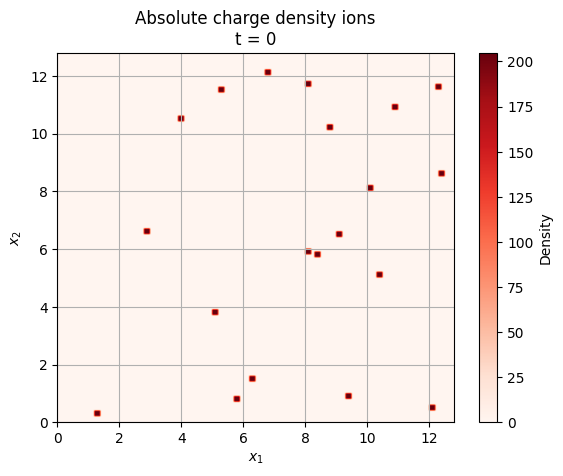

In [3]:
import em2ds as zpic

# Number of grid points
nx = [128, 128]

# Density Profile

## Equally Spaced
# density = zpic.Density(
#     type="dirac",
#     n=nx[0]*nx[1]/21,   # to have a "plasma" at the reference density you must set n = nx*ny / np
#     dirac_dx=[30, 10],  # number of grid points between consecutive particles [x,y]
#     dirac_range=[       # range of grid points where to inject particles
#         [20, 100],      # [xmin, xmax]
#         [60, -1,],      # [ymin, ymax] (-1 is equivalent to the end of the box along this dimension)
#     ],
# )

## Randomly Placed
np_ = 20
density = zpic.Density(
    type="dirac",
    n=nx[0]*nx[1] / np_,  # to have a "plasma" at the reference density you must set n = nx*ny / np
    dirac_random=True,  # activate random positioning
    dirac_random_seed=2,  # can choose a seed, helpful if one wants to place ions exactly on top of electrons
    dirac_random_np=np_,  # number of particles to initialize
)


# Background plasma
electrons = zpic.Species(
    "electrons", -1.0, ppc=[1, 1], density=density  # ppc will be ignored even if set to ppc > 1
)

# Can place for e.g. the ions placed on top of the electrons
ions = zpic.Species(
    "electrons", 1836.0, ppc=[1, 1], density=density, 
)

# Initialize simulation data
sim = zpic.Simulation(nx=nx, box=[12.8, 12.8], dt=0.07, species=[electrons, ions])

import matplotlib.pyplot as plt

charge = np.abs(electrons.charge())
range = [[0, sim.box[0]], [0, sim.box[1]]]

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.imshow(
    charge,
    origin="lower",
    extent=(range[0][0], range[0][1], range[1][0], range[1][1]),
    aspect="auto",
    cmap="Blues",
)
plt.colorbar().set_label("Density")

plt.title("Absolute charge density electrons\nt = {:g}".format(sim.t))

plt.grid(True)
plt.show()


charge = np.abs(ions.charge())
range = [[0, sim.box[0]], [0, sim.box[1]]]

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.imshow(
    charge,
    origin="lower",
    extent=(range[0][0], range[0][1], range[1][0], range[1][1]),
    aspect="auto",
    cmap="Reds",
)
plt.colorbar().set_label("Density")

plt.title("Absolute charge density ions\nt = {:g}".format(sim.t))

plt.grid(True)
plt.show()